# Emotion Recognition with the Vision Transformer (ViT)

### Packages

In [ ]:
import os
import pickle

import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import opendatasets as od
import torch
import torch.nn as nn
import evaluate

from datasets import *
from transformers import ViTImageProcessor
from transformers import ViTModel
from transformers import TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import EarlyStoppingCallback, IntervalStrategy

from torchinfo import summary
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

## Load Data

In [3]:
# Load the dataset from the emotion-detection-fer folder
# This contains two folders, test and train, each with 7 folders, one for each emotion.
# Load data as rgb images label as [img, label] in a pandas dataframe for both test and train

string_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

def load_data(data_dir):
    data = []
    for emotion in os.listdir(data_dir):
        for item in os.listdir(os.path.join(data_dir, emotion)):
            img = cv2.imread(os.path.join(data_dir, emotion, item))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(int).tolist()
            # Convert emotion label to integer label
            index = string_labels.index(emotion)
            data.append([img, index])
    return pd.DataFrame(data, columns=['img', 'label'])

train_ds = Dataset.from_pandas(load_data('emotion-detection-fer/train'))
test_ds = Dataset.from_pandas(load_data('emotion-detection-fer/test'))

## Preprocessing

In [4]:
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

train_validation_ds  = train_ds.train_test_split(test_size=0.2)
train_ds = train_validation_ds["train"]
validation_ds = train_validation_ds["test"]

# Check Proportions
# Of the original 80/20 split for training/testing, training was split again by 80/20 for training/validation. 
print("Train:", len(train_ds))
print("Validation:", len(validation_ds))
print("Test:", len(test_ds))

Train: 22967
Validation: 5742
Test: 7178


In [5]:
def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [ ]:
# features of the new dataset with an additional column for the preprocess 224x224x3 images 
features = Features({
    'label': ClassLabel(names=string_labels),
    'img': Array3D(dtype="int64", shape=(3,48,48)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

# TRAIN
preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, batch_size=1, features=features)
with open('preprocessed_train_ds.pickle', 'wb') as handle:
    pickle.dump(preprocessed_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# VALIDATION
preprocessed_validation_ds = validation_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_validation_ds.pickle', 'wb') as handle:
   pickle.dump(preprocessed_validation_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# TEST
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_test_ds.pickle', 'wb') as handle:
   pickle.dump(preprocessed_test_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

   

### Load Pickle Data
If preprocessed data is already present in the folder, it can just be loaded here to save some time.

In [7]:
# string_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# with open('preprocessed_train_ds.pickle', 'rb') as handle:
#     preprocessed_train_ds = pickle.load(handle)

# with open('preprocessed_validation_ds.pickle', 'rb') as handle:
#     preprocessed_validation_ds = pickle.load(handle)

# with open('preprocessed_test_ds.pickle', 'rb') as handle:
#     preprocessed_test_ds = pickle.load(handle)

## Model

In [8]:
class ViTForImageClassification(nn.Module):
    #define architecture
    def __init__(self, num_labels=len(string_labels)):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [9]:
args = TrainingArguments(
    f"training",
    evaluation_strategy = IntervalStrategy.STEPS,
    eval_steps = 500,
    save_total_limit = 5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "f1",
    logging_dir='logs',
)

In [10]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [11]:
model = ViTForImageClassification()

In [12]:
# checks if cuda is available for use of the gpu.
print("CUDA AVAILABLE:", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = preprocessed_train_ds,
    eval_dataset = preprocessed_validation_ds,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

CUDA AVAILABLE: True


## Train Model

In [ ]:
# training
model.to(device)
trainer.train()

# save the model for later use
trainer.save_model("model")

## Evaluation

In [16]:
outputs = trainer.predict(preprocessed_test_ds)
print(outputs.metrics)

  0%|          | 0/449 [00:00<?, ?it/s]

{'test_loss': 0.9539341926574707, 'test_accuracy': 0.68431317915854, 'test_f1': 0.6510454305177246, 'test_runtime': 233.5717, 'test_samples_per_second': 30.731, 'test_steps_per_second': 1.922}


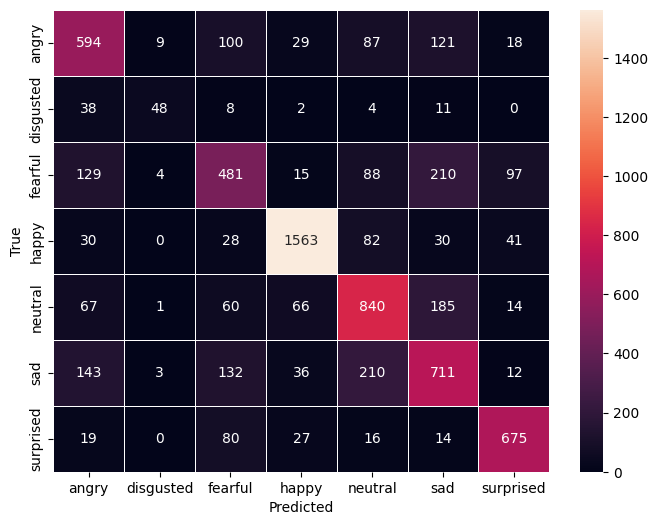

In [17]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
fig, ax = plt.subplots(figsize=(8,6))  
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=string_labels, yticklabels=string_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()